## Main questions
The idea here is to answer these questions:

1. What pre-transfer variables are associated with 30-day mortality in transferred patients?
2. Are there any differences in risk factors in transferred vs. non-transferred (patients directly admittited to a tertiary center ICU)?
3. Is transfer distance a risk factor for 30-day mortality in transferred patients?
3. Is time in the primary icu a risk factor for 30-day mortality in transferred patients?


In answering question 1 a rather bland risk model will be built. It is unlikely that anything new will be discovered. Rather, see this model as a predecessor of the model needed to answer question 2.

By answering question 2, subgroups of patients at high risk of poor outcome can potentially be identified where transfer status acts as a modifier of risk. Such findings would be largely hypothesis generating, as the dataset does not allow for more detailed inquiry. Under the assumtion of no residual confounding, differences depending on transfer status could be explained by the intial care at the primary center, the transfer process or delays to treatment. Clear findings cloud help to identify areas of special interest for future research. As of today (May 2024) the dataset does not allow for this analyis, as there is no way of telling which tertiary ICU patients were directly admitted. We will have to wait for the supplemented data (expected to arrive in summer-fall of 2024).

Question 3 is tricky. Since hospitals are fixed in space, transfer distance becomes as much a surrogate for the sending and receiving centers, as it is a surrogate for the transfer time and the logistics involved in transferring a patient between hospitals. Therefore, any findings are largely hypothesis generating given the nature of the dataset.

## Modeling choices
Generally, bayesian linear hierarchcial models are applied in order to make model intrepretation relatively straightforward.
### Model 1
Here a set of potentially predictive parameters will be used in a generalized linear model. I will test two variations of the model. Both will have a varying intercept with parameters drawn from a common prior. Model 1.1. will imputed missing data from a common prior distribution, where as Model 1.2 will impute the concioussness level predictor from separate distributions for the respective diagnostic group. The latter model (Model 1.2) samples very slow (2+ hours) due to the compound steps in sampling. This is prohibitive of constructing a model with more dynamic missing data handling and varying slopes for all predcitors. Also, divergences start to appear even though the parameterization is non-centered.

### Model 2
This model builds on model 1. A natural way to extend this model would be to add another level in the hierarchical structure: transferred vs. non-transferred patient. As of today, there is not enough data to construct these models.

### Model 3
This idea here is to use distance as a predictor of outcome in a hierarchical model where a level is the receiving tertiary center (model 3.1) or diagnostic group (model 3.2). I will test the implications of using standardized road distance as a linear predictor.

### Model 4
The idea here is to use time-in-primary-icu as a predictor of outcome in a hierarchical model. Sending centers are a level in this model.

## Data preparation
The database is queried. All analysis is done on patients undergoing transfers > 49 km. Only centers transferring five or more patients are included.

In [1]:
# Load dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine, text
import pymc as pm
import arviz as az
from scipy.stats import zscore


# Define the SQLalchemy engine
engine = create_engine(f"sqlite:////Users/JO/PhD/neurocritical-transfers/data/db.sqlite")

# Read the SQL query from the file
with open('/Users/JO/PhD/neurocritical-transfers/notes/final-analysis/0-database-query/primary-based-transfer-query.sql', 'r') as file:
    query = file.read()

# Execute the query
d = pd.read_sql(query, engine)

# Remmap receiving hospital codes to names
hospitals_map = {"11001": "Karolinska universitetssjukhuset, Solna",
 "11003": "Karolinska universitetssjukhuset, Solna",
 "51001": "Sahlgrenska universitetssjukhuset",
 "12001": "Akademiska sjukhuset",
 "21001": "Universitetssjukhuset i Linköping",
 "64001": "Norrlands universitetssjukhus",
 "41001": "Universitetssjukhuset i Lund",
 "41002": "Universitetssjukhuset i Lund"}
d['tertiary_center'] = d.tertiary_center_id.map(hospitals_map)

# Fix admission time so that time zone is clear, also add a admission time in UTC for later merging of data
d["sir_adm_time"] = pd.to_datetime(d["sir_adm_time"], unit='s').dt.tz_localize('Europe/Stockholm')
d['admission_time_utc'] = d["sir_adm_time"].dt.tz_convert('UTC')

# Load dataframes of formatted ICU names and ICU to airport mappings
icu_names = pd.read_csv('/Users/JO/PhD/neurocritical-transfers/data/icu-mapping-names-only.csv', sep=";")

# Remap ICU names to properly formatted ICU names
icu_names_dict = dict(zip(icu_names['sir_icu_name'], icu_names['formatted_icu_name']))
d['formatted_icu_name'] = d.sir_icu_name.map(icu_names_dict)

# Merge with road distance data
r = pd.read_csv('/Users/JO/PhD/neurocritical-transfers/data/road_distance.csv', sep=";")
d['road_distance'] = [r[r['formatted_icu_name'] == p][t].values[0] for (p, t) in zip(d.formatted_icu_name, d.tertiary_center)]

# Filter on distance > 49 km and n=5 per center
d_filtered = d[d['road_distance'] > 49]

grouped = d_filtered.groupby('sir_icu_name')

# Filter groups where the count is greater than or equal to 5
d_filtered = grouped.filter(lambda x: len(x) >= 5)

# Ungroup the DataFrame
d_filtered = d_filtered.reset_index(drop=True)

# Redefine to d
d = d_filtered

# Assert that dataframe is of correct length
assert(len(d) == 6241)

## Model 1: Risk prediction of d30 mortality given pre transfer status

Predictors:

* Sex 
* Age (standardized)

* SAPS conciousness level

* SAPS hypotension (min SBP <90)

* SAPS hypothermia (temp <35)

* SAPS acidosis (pH <7.25)

* SAPS hypoxia (PO2 <8 kPa)

* After-hours admission (yes or no)

Outcome:

* 30-day mortality

Levels:
* Dx group


Model structure:

$y_{i} \sim Bernoulli(p_{i})$

$\text{invlogit}(p_{i}) = \beta_{j,0} + \sum_{k=1}^{n_{k}} \beta_{j,k} \cdot x_{k,i}$

With $i$ samples, $j$ diagnostic groups, $k$ classes of predictors and $x_{k,i}$ predictor values. (Notation might be off...) 

Priors generally look like:

$\beta_{j,0} \sim Normal(\bar{\mu_{0}}, \bar{\sigma_{0}})$

$\bar{\mu_{0}} \sim Normal(0, 1)$

$\bar{\sigma_{0}} \sim Exp(1)$

$\beta_{j,k} \sim Normal(\bar{\mu_{k}}, \bar{\sigma_{k}})$

$\bar{\mu_{k}} \sim Normal(0, 1)$

$\bar{\sigma_{k}} \sim Exp(1)$

### Model 1.1

In [2]:
COORDS = {'sample': np.arange(len(d)), 'dx': pd.factorize(d['DX'], use_na_sentinel=False, sort=True)[1], 'sir_consciousness_level': pd.factorize(d['sir_consciousness_level'], use_na_sentinel=True, sort=True)[1]}
with pm.Model(coords=COORDS) as m1_1:
    idx_dx, _ = pd.factorize(d['DX'], sort=True)
    female = d['sex_female']
    icu_admission_afterhours = d['icu_admission_afterhours']
    conciousness, _ = pd.factorize(d.sir_consciousness_level, use_na_sentinel=True, sort=True)
    conciousness = np.ma.masked_equal(conciousness, -1)
    hypotension, _ = pd.factorize(d.SAPS_hypotension, use_na_sentinel=True, sort=True)
    hypotension  = np.ma.masked_equal(hypotension, -1)
    hypothermia, _ = pd.factorize(d.SAPS_hypothermia, use_na_sentinel=True, sort=True)
    hypothermia  = np.ma.masked_equal(hypothermia, -1)
    hypoxia, _ = pd.factorize(d.SAPS_hypoxia, use_na_sentinel=True, sort=True)
    hypoxia  = np.ma.masked_equal(hypoxia, -1)
    acidosis, _ = pd.factorize(d.SAPS_acidosis, use_na_sentinel=True, sort=True)
    acidosis  = np.ma.masked_equal(acidosis, -1)
    age = zscore(d['age'])
    
    # Varying intercept with non-centered parameterization
    mu_bar0 = pm.Normal('alpha_bar0', 0, 1)
    sigma_bar0 = pm.Exponential('sigma_bar0', 1)
    z_beta0 = pm.Normal('z_beta0', 0, 1, dims='dx')
    beta_0 = pm.Deterministic('beta_0', mu_bar0 + z_beta0 * sigma_bar0, dims='dx')

    # slope for female (0/1)
    beta_female = pm.Normal('beta_female', 0, 1)

    # slope for afterhours (0/1) 
    beta_icu_admission_afterhours = pm.Normal('beta_icu_admission_afterhours', 0, 1)

    # slope for std_age
    beta_age = pm.Normal('beta_age', 0, 1)

    # intercepts for for (categorical) conciousness level with missing data handling
    p_con = pm.Dirichlet('p_con', a=np.ones(5), dims=('sir_consciousness_level'))
    conciousness_imputed = pm.Categorical('con_imputed', p=p_con, dims='sample', observed=conciousness)
    beta_conciousness = pm.Normal('beta_conciousness', 0, 1, dims='sir_consciousness_level')

    # slope for hypotension with missing data handling (non hierarchical imputation) 
    p_hypotension = pm.Normal('p_hypotension', -2, 2)
    hypotension_imputed = pm.Bernoulli('hypotension_imputed', logit_p=p_hypotension, dims='sample', observed=hypotension)
    beta_hypotension = pm.Normal('beta_hypotension', 0, 1)

    # slope for hypothermia with missing data handling (non hierarchical imputation)
    p_hypothermia = pm.Normal('p_hypothermia', -2, 2)
    hypothermia_imputed = pm.Bernoulli('hypothermia_imputed', logit_p=p_hypothermia, dims='sample', observed=hypothermia)
    beta_hypothermia = pm.Normal('beta_hypothermia', 0, 1)

    # slope for hypoxia with missing data handling (non hierarchical imputation)
    p_hypoxia = pm.Normal('p_hypoxia', -2, 2)
    hypoxia_imputed = pm.Bernoulli('hypoxia_imputed', logit_p=p_hypoxia, dims='sample', observed=hypoxia)
    beta_hypoxia = pm.Normal('beta_hypoxia', 0, 1)

    # slope for acidosis with missing data handling (non hierarchical imputation)
    p_acidosis = pm.Normal('p_acidosis', -2, 2)
    acidosis_imputed = pm.Bernoulli('acidosis_imputed', logit_p=p_acidosis, dims='sample', observed=acidosis)
    beta_acidosis = pm.Normal('beta_acidosis', 0, 1)

    p_i = pm.Deterministic('p_i', beta_0[idx_dx] + beta_female * female + beta_icu_admission_afterhours * icu_admission_afterhours + beta_age * age + beta_conciousness[conciousness_imputed] + beta_hypotension * hypotension_imputed + beta_hypothermia * hypothermia_imputed + beta_hypoxia * hypoxia_imputed + beta_acidosis * acidosis_imputed, dims='sample')
    Y = pm.Bernoulli('Y', logit_p=p_i, observed=d['d30'], dims='sample')

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in con_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypotension_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypothermia_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypoxia_imputed conta

In [3]:
with m1_1:
    idata_1_1 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha_bar0, sigma_bar0, z_beta0, beta_female, beta_icu_admission_afterhours, beta_age, p_con, beta_conciousness, p_hypotension, beta_hypotension, p_hypothermia, beta_hypothermia, p_hypoxia, beta_hypoxia, p_acidosis, beta_acidosis]
>CategoricalGibbsMetropolis: [con_imputed_unobserved]
>BinaryGibbsMetropolis: [hypotension_imputed_unobserved, hypothermia_imputed_unobserved, hypoxia_imputed_unobserved, acidosis_imputed_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4752 seconds.


### Model 1.2

In [4]:
COORDS = {'sample': np.arange(len(d)), 'dx': pd.factorize(d['DX'], use_na_sentinel=False, sort=True)[1], 'sir_consciousness_level': pd.factorize(d['sir_consciousness_level'], use_na_sentinel=True, sort=True)[1]}
with pm.Model(coords=COORDS) as m1_2:
    idx_dx, _ = pd.factorize(d['DX'], sort=True)
    female = d['sex_female']
    icu_admission_afterhours = d['icu_admission_afterhours']
    age = zscore(d['age'])
    conciousness, _ = pd.factorize(d.sir_consciousness_level, use_na_sentinel=True, sort=True)
    conciousness = np.ma.masked_equal(conciousness, -1)
    hypotension, _ = pd.factorize(d.SAPS_hypotension, use_na_sentinel=True, sort=True)
    hypotension  = np.ma.masked_equal(hypotension, -1)
    hypothermia, _ = pd.factorize(d.SAPS_hypothermia, use_na_sentinel=True, sort=True)
    hypothermia  = np.ma.masked_equal(hypothermia, -1)
    hypoxia, _ = pd.factorize(d.SAPS_hypoxia, use_na_sentinel=True, sort=True)
    hypoxia  = np.ma.masked_equal(hypoxia, -1)
    acidosis, _ = pd.factorize(d.SAPS_acidosis, use_na_sentinel=True, sort=True)
    acidosis  = np.ma.masked_equal(acidosis, -1)
    
    # Varying intercept with non-centered parameterization
    mu_bar0 = pm.Normal('alpha_bar0', 0, 1)
    sigma_bar0 = pm.Exponential('sigma_bar0', 1)
    z_beta0 = pm.Normal('z_beta0', 0, 1, dims='dx')
    beta_0 = pm.Deterministic('beta_0', mu_bar0 + z_beta0 * sigma_bar0, dims='dx')

    # slope for female (0/1)
    beta_female = pm.Normal('beta_female', 0, 1)

    # slope for afterhours (0/1) 
    beta_icu_admission_afterhours = pm.Normal('beta_icu_admission_afterhours', 0, 1)

    # slope for std_age
    beta_age = pm.Normal('beta_age', 0, 1)

    # Intercepts for (categorical) conciousness level with missing data (separate distributions per dx group) handling non-centered parameterization,
    p_con = pm.Dirichlet('p_con', a=np.ones((13,5)), dims=('dx', 'sir_consciousness_level'))
    conciousness_imputed = pm.Categorical('con_imputed', p=p_con[idx_dx,:], dims='sample', observed=conciousness)
    mu_bar_conciousness = pm.Normal('mu_bar_conciousness', 0, 1)
    sigma_bar_conciousness = pm.Exponential('sigma_bar_conciousness', 1)
    z_beta_conciousness = pm.Normal('z_beta_conciousness', 0, 1, dims='sir_consciousness_level')
    beta_conciousness = pm.Deterministic('beta_conciousness', mu_bar_conciousness + z_beta_conciousness * sigma_bar_conciousness, dims='sir_consciousness_level')

    # slope for hypotension with missing data handling (non hierarchical imputation) 
    p_hypotension = pm.Normal('p_hypotension', -2, 2)
    hypotension_imputed = pm.Bernoulli('hypotension_imputed', logit_p=p_hypotension, dims='sample', observed=hypotension)
    beta_hypotension = pm.Normal('beta_hypotension', 0, 1)

    # slope for hypothermia with missing data handling (non hierarchical imputation)
    p_hypothermia = pm.Normal('p_hypothermia', -2, 2)
    hypothermia_imputed = pm.Bernoulli('hypothermia_imputed', logit_p=p_hypothermia, dims='sample', observed=hypothermia)
    beta_hypothermia = pm.Normal('beta_hypothermia', 0, 1)

    # slope for hypoxia with missing data handling (non hierarchical imputation)
    p_hypoxia = pm.Normal('p_hypoxia', -2, 2)
    hypoxia_imputed = pm.Bernoulli('hypoxia_imputed', logit_p=p_hypoxia, dims='sample', observed=hypoxia)
    beta_hypoxia = pm.Normal('beta_hypoxia', 0, 1)

    # slope for acidosis with missing data handling (non hierarchical imputation)
    p_acidosis = pm.Normal('p_acidosis', -2, 2)
    acidosis_imputed = pm.Bernoulli('acidosis_imputed', logit_p=p_acidosis, dims='sample', observed=acidosis)
    beta_acidosis = pm.Normal('beta_acidosis', 0, 1)

    p_i = pm.Deterministic('p_i', beta_0[idx_dx] + beta_female * female + beta_icu_admission_afterhours * icu_admission_afterhours + beta_age * age + beta_conciousness[conciousness_imputed] + beta_hypotension * hypotension_imputed + beta_hypothermia * hypothermia_imputed + beta_hypoxia * hypoxia_imputed + beta_acidosis * acidosis_imputed, dims='sample')
    Y = pm.Bernoulli('Y', logit_p=p_i, observed=d['d30'], dims='sample')

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in con_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypotension_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypothermia_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypoxia_imputed conta

In [5]:
with m1_2:
    idata_1_2 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha_bar0, sigma_bar0, z_beta0, beta_female, beta_icu_admission_afterhours, beta_age, p_con, mu_bar_conciousness, sigma_bar_conciousness, z_beta_conciousness, p_hypotension, beta_hypotension, p_hypothermia, beta_hypothermia, p_hypoxia, beta_hypoxia, p_acidosis, beta_acidosis]
>CategoricalGibbsMetropolis: [con_imputed_unobserved]
>BinaryGibbsMetropolis: [hypotension_imputed_unobserved, hypothermia_imputed_unobserved, hypoxia_imputed_unobserved, acidosis_imputed_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8248 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


### Posteriors of model 1 parameters

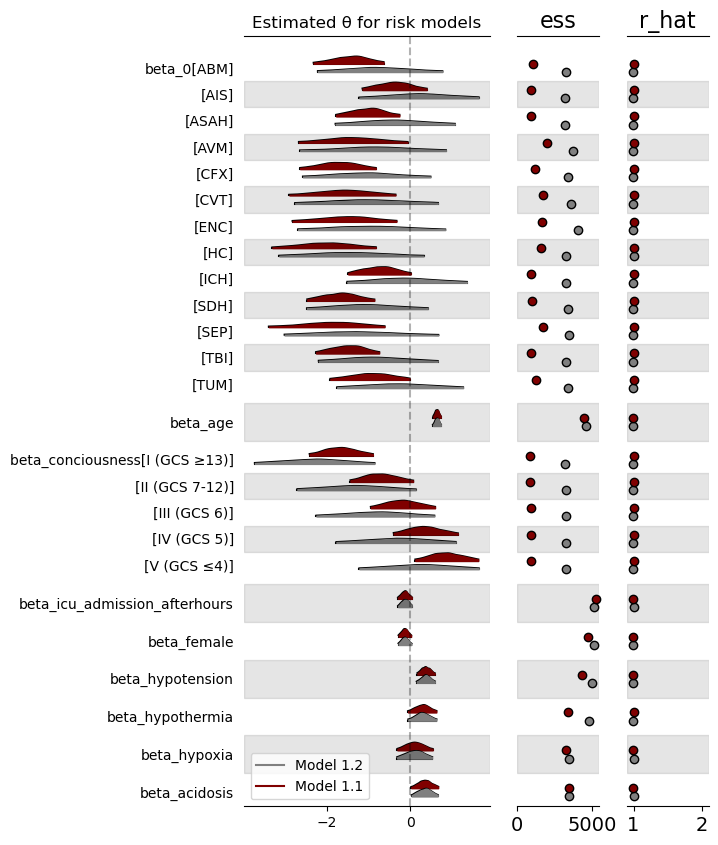

In [57]:
axes = az.plot_forest(
    [idata_1_1, idata_1_2],
    model_names=[
        'Model 1.1',
        'Model 1.2'
    ],
    kind='ridgeplot', ess=True,
    r_hat=True,
    ridgeplot_overlap=0.7,
    colors=['maroon', 'grey'],
    hdi_prob=0.94,
    combined=True,
    var_names=[
        'beta_0',
        'beta_age',
        'beta_conciousness',
        'beta_icu_admission_afterhours',
        'beta_female',
        'beta_hypotension',
        'beta_hypothermia',
        'beta_hypoxia',
        'beta_acidosis'], 
    figsize=(6,10))
axes[0].set_title('Estimated θ for risk models')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3);

#### Comments on model 1
Both models seem to share the same predictors for 30-day mortality. Increasing age, lower levels of conciousness and hypotension seem to predict mortality. To a lesser extent hypoxia, hypothermia and acidosis predict mortality. The intercepts for AIS, ICH, ASAH and TUM tend to be higher, reflecting higher mortality risks in these groups.

In essence, there is nothing interesting to see here. Being old and/or sick is bad. However, it would be interesting to compare these patients with non-transfers and find that some predictors are more/less important in any of the groups.

## Model 2

N/A

## Model 3
Here, distance will be used as a predictor. Model 3.1 will model distance with varying slopes where receving centers will be a level. Model 3.2 will model distance with varying slopes where diagnostic group will be a level. Varying $\beta_{0}$ intercepts are used in both models. The slopes/intercepts for the other predictors are completely pooled.

### Model 3.1

In [6]:
COORDS = {'sample': np.arange(len(d)), 'hospital_type': pd.factorize(d['sir_hospital_type'], sort=True)[1], 'center': pd.factorize(d['tertiary_center'], sort=True)[1], 'dx': pd.factorize(d['DX'], use_na_sentinel=False, sort=True)[1], 'sir_consciousness_level': pd.factorize(d['sir_consciousness_level'], use_na_sentinel=True, sort=True)[1]}
with pm.Model(coords=COORDS) as m3_1:
    idx_dx, _ = pd.factorize(d['DX'], sort=True)
    idx_center, _ = pd.factorize(d['tertiary_center'], sort=True)
    idx_center_type, _ = pd.factorize(d['sir_hospital_type'], sort=True)
    distance = zscore(d.road_distance)
    female = d['sex_female']
    icu_admission_afterhours = d['icu_admission_afterhours']
    age = zscore(d['age'])
    conciousness, _ = pd.factorize(d.sir_consciousness_level, use_na_sentinel=True, sort=True)
    conciousness = np.ma.masked_equal(conciousness, -1)
    hypotension, _ = pd.factorize(d.SAPS_hypotension, use_na_sentinel=True, sort=True)
    hypotension  = np.ma.masked_equal(hypotension, -1)
    hypothermia, _ = pd.factorize(d.SAPS_hypothermia, use_na_sentinel=True, sort=True)
    hypothermia  = np.ma.masked_equal(hypothermia, -1)
    hypoxia, _ = pd.factorize(d.SAPS_hypoxia, use_na_sentinel=True, sort=True)
    hypoxia  = np.ma.masked_equal(hypoxia, -1)
    acidosis, _ = pd.factorize(d.SAPS_acidosis, use_na_sentinel=True, sort=True)
    acidosis  = np.ma.masked_equal(acidosis, -1)

    # varying intercept
    mu_bar_0 = pm.Normal('mu_bar_0', 0, 1)
    sigma_bar_0 = pm.Exponential('sigma_bar_0', 1)
    z_beta_0 = pm.Normal('z_beta_0', 0, 1, dims='center')
    beta_0 = pm.Deterministic('beta_0', mu_bar_0 + z_beta_0 * sigma_bar_0, dims='center')

    # varying slope for distance
    mu_bar_distance = pm.Normal('mu_bar_distance', 0, 1)
    sigma_bar_distance = pm.Exponential('sigma_bar_distance', 1)
    z_beta_distance = pm.Normal('z_beta_distance', 0, 1, dims='center')
    beta_distance = pm.Deterministic('beta_distance', mu_bar_distance + z_beta_distance * sigma_bar_distance, dims='center')

    # fixed slope, impact of age
    beta_age = pm.Normal('beta_age', 0, 1)

    # fixed intercept, impact of conciousness
    p_con = pm.Dirichlet('p_con', a=np.ones(5), dims=('sir_consciousness_level'))
    conciousness_imputed = pm.Categorical('con_imputed', p=p_con, dims='sample', observed=conciousness)
    beta_conciousness = pm.Normal('beta_conciousness', 0, 1, dims='sir_consciousness_level')

    # fixed intercepts, impact of sending hospital type
    beta_hospital_type = pm.Normal('beta_hospital_type', 0, 1, dims='hospital_type')

    # adjust for dx
    beta_dx_group = pm.Normal('beta_dx_group', 0, 1, dims='dx')

    # slope for hypotension with missing data handling (non hierarchical imputation) 
    p_hypotension = pm.Normal('p_hypotension', -2, 2)
    hypotension_imputed = pm.Bernoulli('hypotension_imputed', logit_p=p_hypotension, dims='sample', observed=hypotension)
    beta_hypotension = pm.Normal('beta_hypotension', 0, 1)
    

    p_i = pm.Deterministic('p_i', beta_0[idx_center] + beta_dx_group[idx_dx] +  beta_distance[idx_center] * distance + beta_hospital_type[idx_center_type] + beta_conciousness[conciousness_imputed] +  beta_age * age + beta_hypotension * hypotension_imputed, dims='sample')
    Y = pm.Bernoulli('Y', logit_p=p_i, observed=d['d30'], dims='sample')

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in con_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypotension_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [7]:
with m3_1:
    idata_3_1 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_bar_0, sigma_bar_0, z_beta_0, mu_bar_distance, sigma_bar_distance, z_beta_distance, beta_age, p_con, beta_conciousness, beta_hospital_type, beta_dx_group, p_hypotension, beta_hypotension]
>CategoricalGibbsMetropolis: [con_imputed_unobserved]
>BinaryGibbsMetropolis: [hypotension_imputed_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 566 seconds.


### Model 3.2

In [9]:
COORDS = {'sample': np.arange(len(d)), 'hospital_type': pd.factorize(d['sir_hospital_type'], sort=True)[1], 'center': pd.factorize(d['tertiary_center'], sort=True)[1], 'dx': pd.factorize(d['DX'], use_na_sentinel=False, sort=True)[1], 'sir_consciousness_level': pd.factorize(d['sir_consciousness_level'], use_na_sentinel=True, sort=True)[1]}
with pm.Model(coords=COORDS) as m3_2:
    idx_dx, _ = pd.factorize(d['DX'], sort=True)
    idx_center, _ = pd.factorize(d['tertiary_center'], sort=True)
    idx_center_type, _ = pd.factorize(d['sir_hospital_type'], sort=True)
    distance = zscore(d.road_distance)
    female = d['sex_female']
    icu_admission_afterhours = d['icu_admission_afterhours']
    age = zscore(d['age'])
    conciousness, _ = pd.factorize(d.sir_consciousness_level, use_na_sentinel=True, sort=True)
    conciousness = np.ma.masked_equal(conciousness, -1)
    hypotension, _ = pd.factorize(d.SAPS_hypotension, use_na_sentinel=True, sort=True)
    hypotension  = np.ma.masked_equal(hypotension, -1)
    hypothermia, _ = pd.factorize(d.SAPS_hypothermia, use_na_sentinel=True, sort=True)
    hypothermia  = np.ma.masked_equal(hypothermia, -1)
    hypoxia, _ = pd.factorize(d.SAPS_hypoxia, use_na_sentinel=True, sort=True)
    hypoxia  = np.ma.masked_equal(hypoxia, -1)
    acidosis, _ = pd.factorize(d.SAPS_acidosis, use_na_sentinel=True, sort=True)
    acidosis  = np.ma.masked_equal(acidosis, -1)

    # varying intercept
    mu_bar_0 = pm.Normal('mu_bar_0', 0, 1)
    sigma_bar_0 = pm.Exponential('sigma_bar_0', 1)
    z_beta_0 = pm.Normal('z_beta_0', 0, 1, dims='dx')
    beta_0 = pm.Deterministic('beta_0', mu_bar_0 + z_beta_0 * sigma_bar_0, dims='dx')

    # varying slope for distance
    mu_bar_distance = pm.Normal('mu_bar_distance', 0, 1)
    sigma_bar_distance = pm.Exponential('sigma_bar_distance', 1)
    z_beta_distance = pm.Normal('z_beta_distance', 0, 1, dims='dx')
    beta_distance = pm.Deterministic('beta_distance', mu_bar_distance + z_beta_distance * sigma_bar_distance, dims='dx')

    # fixed slope, impact of age
    beta_age = pm.Normal('beta_age', 0, 1)

    # fixed intercept, impact of conciousness
    p_con = pm.Dirichlet('p_con', a=np.ones(5), dims=('sir_consciousness_level'))
    conciousness_imputed = pm.Categorical('con_imputed', p=p_con, dims='sample', observed=conciousness)
    beta_conciousness = pm.Normal('beta_conciousness', 0, 1, dims='sir_consciousness_level')

    # fixed intercepts, impact of sending hospital type
    beta_hospital_type = pm.Normal('beta_hospital_type', 0, 1, dims='hospital_type')

    # adjust for center
    beta_center = pm.Normal('beta_center', 0, 1, dims='center')

    # slope for hypotension with missing data handling (non hierarchical imputation) 
    p_hypotension = pm.Normal('p_hypotension', -2, 2)
    hypotension_imputed = pm.Bernoulli('hypotension_imputed', logit_p=p_hypotension, dims='sample', observed=hypotension)
    beta_hypotension = pm.Normal('beta_hypotension', 0, 1)
    

    p_i = pm.Deterministic('p_i', beta_0[idx_dx] +  beta_center[idx_center] + beta_distance[idx_dx] * distance + beta_hospital_type[idx_center_type] + beta_conciousness[conciousness_imputed] +  beta_age * age + beta_hypotension * hypotension_imputed, dims='sample')
    Y = pm.Bernoulli('Y', logit_p=p_i, observed=d['d30'], dims='sample')

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in con_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypotension_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [10]:
with m3_2:
    idata_3_2 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_bar_0, sigma_bar_0, z_beta_0, mu_bar_distance, sigma_bar_distance, z_beta_distance, beta_age, p_con, beta_conciousness, beta_hospital_type, beta_center, p_hypotension, beta_hypotension]
>CategoricalGibbsMetropolis: [con_imputed_unobserved]
>BinaryGibbsMetropolis: [hypotension_imputed_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 580 seconds.


### Posteriors of model 3 parameters

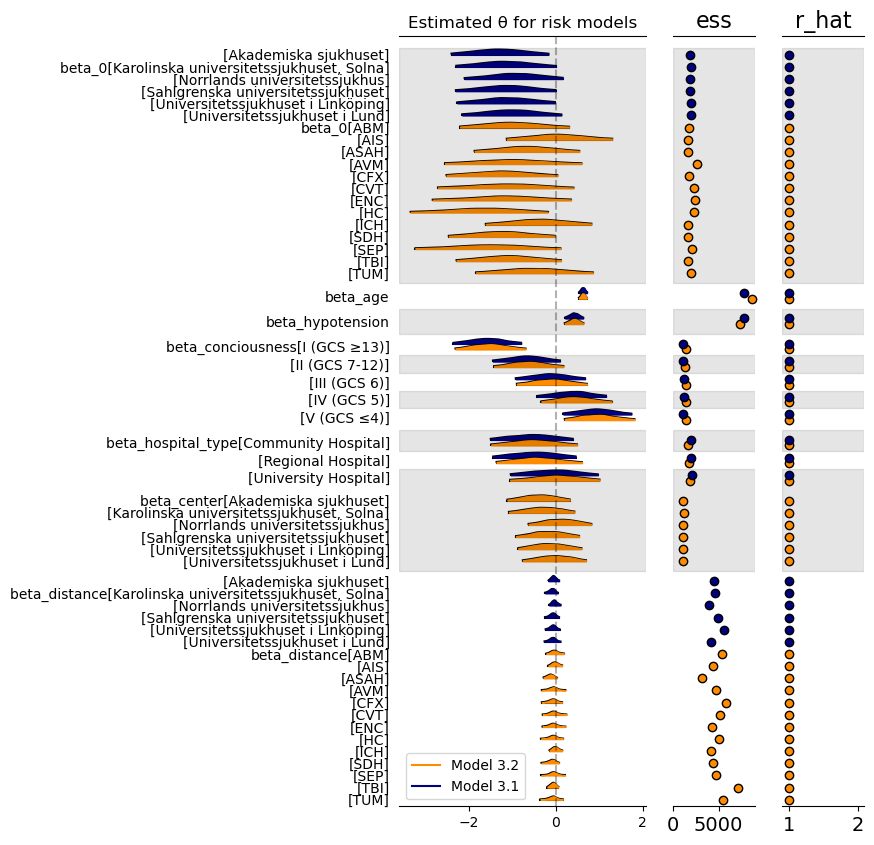

In [58]:
axes = az.plot_forest(
    [idata_3_1, idata_3_2],
    model_names=[
        'Model 3.1',
        'Model 3.2'
    ],
    kind='ridgeplot', ess=True,
    r_hat=True,
    colors=['navy', 'darkorange'],
    ridgeplot_overlap=0.7,
    hdi_prob=0.94,
    combined=True,
    var_names=['beta_0', 'beta_age', 'beta_hypotension', 'beta_conciousness', 'beta_hospital_type','beta_center','beta_distance',],
    figsize=(6,10))
axes[0].set_title('Estimated θ for risk models')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3);

Only the distance parameters now:

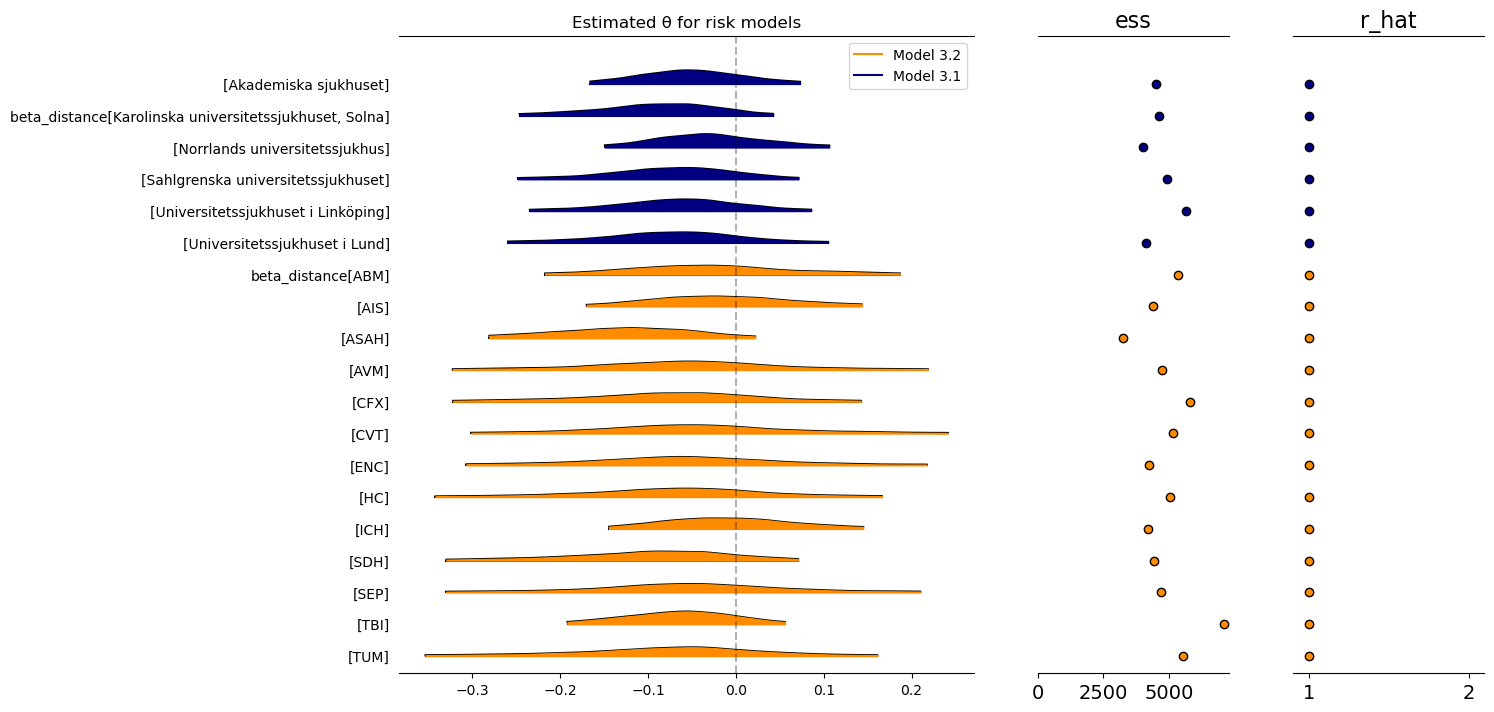

In [62]:
axes = az.plot_forest(
    [idata_3_1, idata_3_2],
    model_names=[
        'Model 3.1',
        'Model 3.2'
    ],
    kind='ridgeplot', ess=True,
    r_hat=True,
    colors=['navy', 'darkorange'],
    ridgeplot_overlap=0.7,
    hdi_prob=0.94,
    combined=True,
    var_names=['beta_distance',])
axes[0].set_title('Estimated θ for risk models')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3);

#### Comments
Again, being older, hypotensive and less concious is bad. Distance has no clear predictive role nomatter the model specification (dx or centers as levels).

## Model 4
In model 4.1 the sending center will define the top level of hierarchy. Varying intercept and slope for effect of standardized time in ICU. The other predictor coefficients are completely pooled.
In model 4.2 the diagnostic group will define the top level instead. Receiving center is a predictor. Otherwise the model structure is the same as in model 4.1.

In [87]:
COORDS = {'sample': np.arange(len(d)), 'hospital_type': pd.factorize(d['sir_hospital_type'], sort=True)[1], 'center': pd.factorize(d['formatted_icu_name'], sort=True)[1], 'dx': pd.factorize(d['DX'], use_na_sentinel=False, sort=True)[1], 'sir_consciousness_level': pd.factorize(d['sir_consciousness_level'], use_na_sentinel=True, sort=True)[1]}
with pm.Model(coords=COORDS) as m4_1:
    idx_dx, _ = pd.factorize(d['DX'], sort=True)
    idx_center, _ = pd.factorize(d['formatted_icu_name'], sort=True)
    idx_center_type, _ = pd.factorize(d['sir_hospital_type'], sort=True)
    distance = zscore(d.road_distance)
    female = d['sex_female']
    icu_admission_afterhours = d['icu_admission_afterhours']
    age = zscore(d['age'])
    conciousness, _ = pd.factorize(d.sir_consciousness_level, use_na_sentinel=True, sort=True)
    conciousness = np.ma.masked_equal(conciousness, -1)
    hypotension, _ = pd.factorize(d.SAPS_hypotension, use_na_sentinel=True, sort=True)
    hypotension  = np.ma.masked_equal(hypotension, -1)
    hypothermia, _ = pd.factorize(d.SAPS_hypothermia, use_na_sentinel=True, sort=True)
    hypothermia  = np.ma.masked_equal(hypothermia, -1)
    hypoxia, _ = pd.factorize(d.SAPS_hypoxia, use_na_sentinel=True, sort=True)
    hypoxia  = np.ma.masked_equal(hypoxia, -1)
    acidosis, _ = pd.factorize(d.SAPS_acidosis, use_na_sentinel=True, sort=True)
    acidosis  = np.ma.masked_equal(acidosis, -1)
    time = zscore(d['sir_total_time'])

    # varying intercept
    mu_bar_0 = pm.Normal('mu_bar_0', 0, 1)
    sigma_bar_0 = pm.Exponential('sigma_bar_0', 1)
    z_beta_0 = pm.Normal('z_beta_0', 0, 1, dims='center')
    beta_0 = pm.Deterministic('beta_0', mu_bar_0 + z_beta_0 * sigma_bar_0, dims='center')

    # varying slope for time
    mu_bar_time = pm.Normal('mu_bar_time', 0, 1)
    sigma_bar_time = pm.Exponential('sigma_bar_time', 1)
    z_beta_time = pm.Normal('z_beta_time', 0, 1, dims='center')
    beta_time = pm.Deterministic('beta_time', mu_bar_time + z_beta_time * sigma_bar_time, dims='center')

    # fixed slope, impact of age
    beta_age = pm.Normal('beta_age', 0, 1)

    # fixed slope, impact of female
    beta_female = pm.Normal('beta_female', 0, 1)

    # fixed intercept, impact of conciousness
    p_con = pm.Dirichlet('p_con', a=np.ones(5), dims=('sir_consciousness_level'))
    conciousness_imputed = pm.Categorical('con_imputed', p=p_con, dims='sample', observed=conciousness)
    beta_conciousness = pm.Normal('beta_conciousness', 0, 1, dims='sir_consciousness_level')

    # slope for hypotension with missing data handling (non hierarchical imputation) 
    p_hypotension = pm.Normal('p_hypotension', -2, 2)
    hypotension_imputed = pm.Bernoulli('hypotension_imputed', logit_p=p_hypotension, dims='sample', observed=hypotension)
    beta_hypotension = pm.Normal('beta_hypotension', 0, 1)

    # slope for hypothermia with missing data handling (non hierarchical imputation)
    p_hypothermia = pm.Normal('p_hypothermia', -2, 2)
    hypothermia_imputed = pm.Bernoulli('hypothermia_imputed', logit_p=p_hypothermia, dims='sample', observed=hypothermia)
    beta_hypothermia = pm.Normal('beta_hypothermia', 0, 1)

    # slope for hypoxia with missing data handling (non hierarchical imputation)
    p_hypoxia = pm.Normal('p_hypoxia', -2, 2)
    hypoxia_imputed = pm.Bernoulli('hypoxia_imputed', logit_p=p_hypoxia, dims='sample', observed=hypoxia)
    beta_hypoxia = pm.Normal('beta_hypoxia', 0, 1)

    # slope for acidosis with missing data handling (non hierarchical imputation)
    p_acidosis = pm.Normal('p_acidosis', -2, 2)
    acidosis_imputed = pm.Bernoulli('acidosis_imputed', logit_p=p_acidosis, dims='sample', observed=acidosis)
    beta_acidosis = pm.Normal('beta_acidosis', 0, 1)

    # intercepts for dx group
    beta_dx_group = pm.Normal('beta_dx_group', 0, 1, dims='dx')

    p_i = pm.Deterministic('p_i', beta_0[idx_center] + beta_time[idx_center] * time + beta_female * beta_female + beta_conciousness[conciousness_imputed] + beta_age * age + beta_hypotension * hypotension_imputed + beta_hypothermia * hypotension_imputed + beta_hypoxia * hypoxia_imputed + beta_acidosis * acidosis_imputed + beta_dx_group[idx_dx], dims='sample')
    Y = pm.Bernoulli('Y', logit_p=p_i, observed=d['d30'], dims='sample')

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in con_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypotension_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypothermia_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypoxia_imputed conta

In [88]:
with m4_1:
    idata_4_1 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_bar_0, sigma_bar_0, z_beta_0, mu_bar_time, sigma_bar_time, z_beta_time, beta_age, beta_female, p_con, beta_conciousness, p_hypotension, beta_hypotension, p_hypothermia, beta_hypothermia, p_hypoxia, beta_hypoxia, p_acidosis, beta_acidosis, beta_dx_group]
>CategoricalGibbsMetropolis: [con_imputed_unobserved]
>BinaryGibbsMetropolis: [hypotension_imputed_unobserved, hypothermia_imputed_unobserved, hypoxia_imputed_unobserved, acidosis_imputed_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7921 seconds.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.


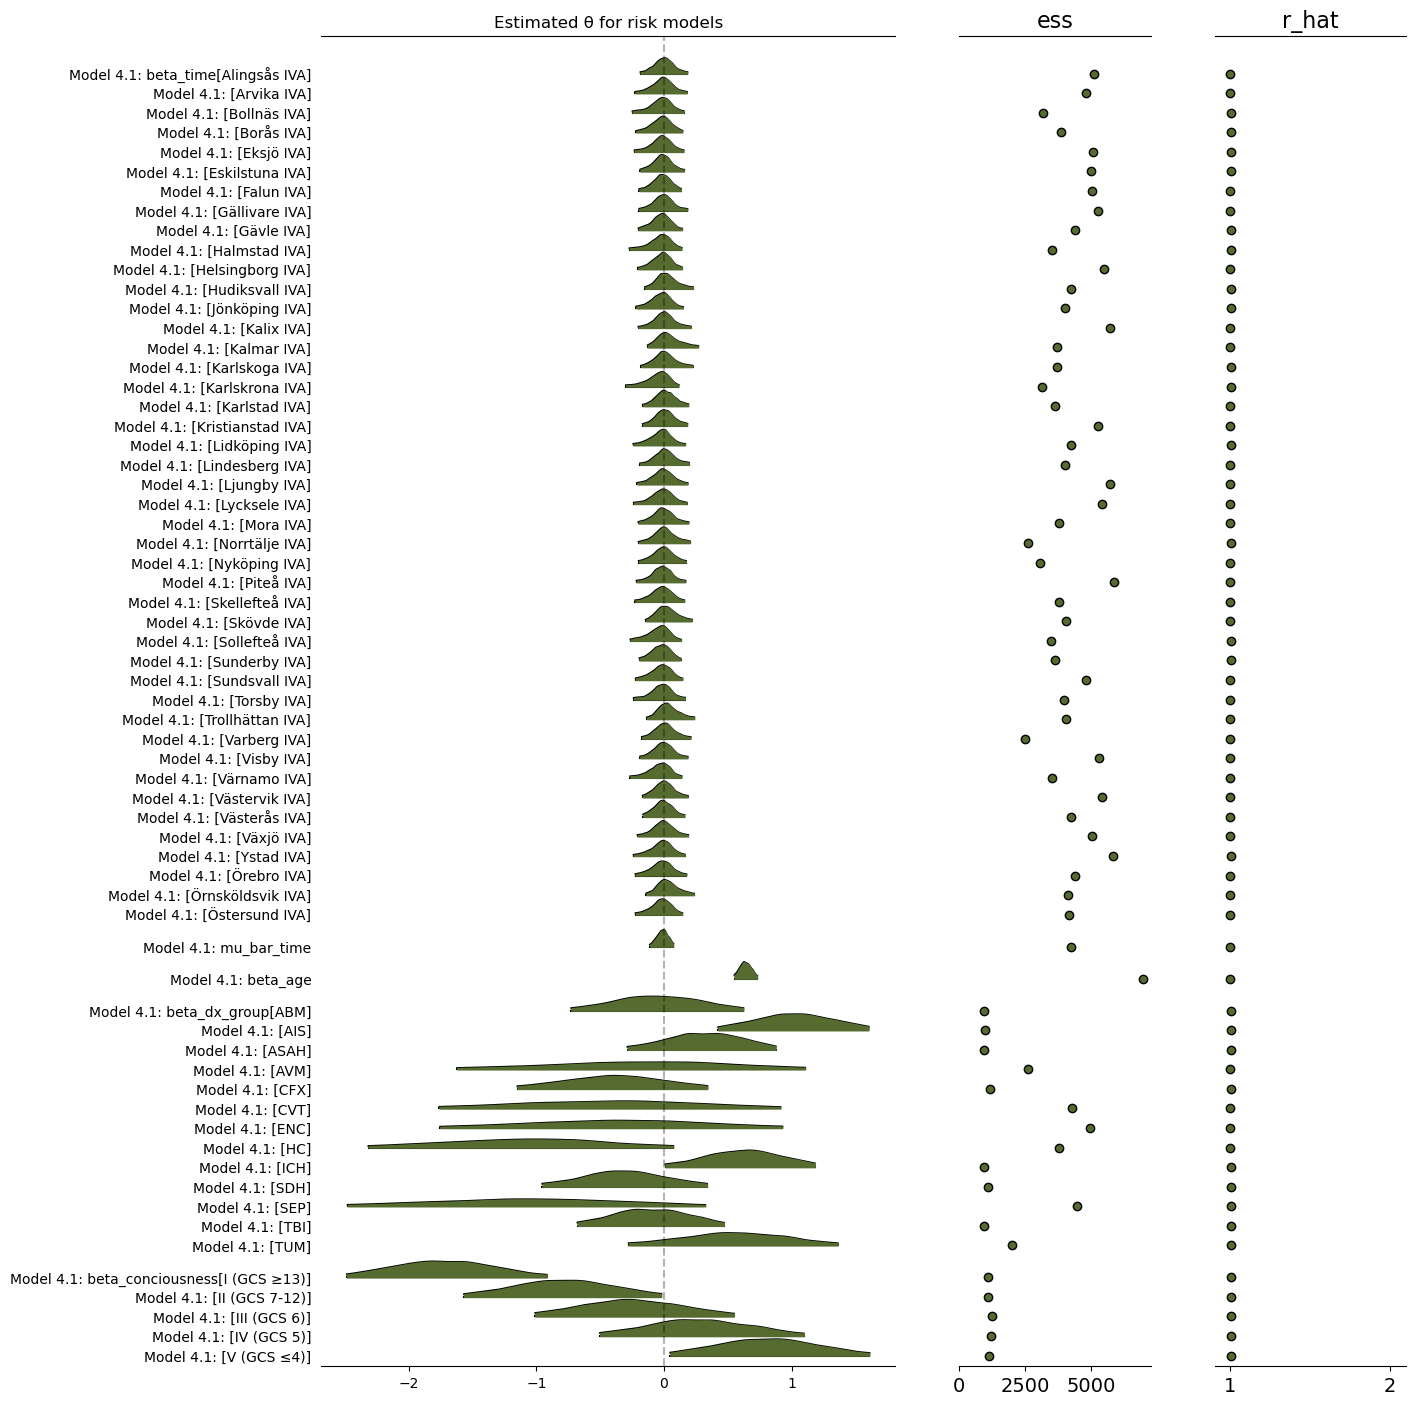

In [92]:
axes = az.plot_forest(
    [idata_4_1],
    model_names=[
        'Model 4.1'
    ],
    kind='ridgeplot', ess=True,
    r_hat=True,
    colors=['darkolivegreen'],
    ridgeplot_overlap=0.7,
    hdi_prob=0.94,
    combined=True,
    var_names=['beta_time', 'mu_bar_time', 'beta_age', 'beta_dx_group', 'beta_conciousness'])
axes[0].set_title('Estimated θ for risk models')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3);

Time spent in primary ICU is not predicitve of 30-day mortality. Finally, let's try a model where diagnostic group is the top level. The choice of covariates is a more limited set to decrease sampling time.

In [103]:
COORDS = {'sample': np.arange(len(d)), 'hospital_type': pd.factorize(d['sir_hospital_type'], sort=True)[1], 'center': pd.factorize(d['tertiary_center'], sort=True)[1], 'dx': pd.factorize(d['DX'], use_na_sentinel=False, sort=True)[1], 'sir_consciousness_level': pd.factorize(d['sir_consciousness_level'], use_na_sentinel=True, sort=True)[1]}
with pm.Model(coords=COORDS) as m4_2:
    idx_dx, _ = pd.factorize(d['DX'], sort=True)
    idx_center, _ = pd.factorize(d['tertiary_center'], sort=True)
    idx_center_type, _ = pd.factorize(d['sir_hospital_type'], sort=True)
    distance = zscore(d.road_distance)
    female = d['sex_female']
    icu_admission_afterhours = d['icu_admission_afterhours']
    age = zscore(d['age'])
    conciousness, _ = pd.factorize(d.sir_consciousness_level, use_na_sentinel=True, sort=True)
    conciousness = np.ma.masked_equal(conciousness, -1)
    hypotension, _ = pd.factorize(d.SAPS_hypotension, use_na_sentinel=True, sort=True)
    hypotension  = np.ma.masked_equal(hypotension, -1)
    hypothermia, _ = pd.factorize(d.SAPS_hypothermia, use_na_sentinel=True, sort=True)
    hypothermia  = np.ma.masked_equal(hypothermia, -1)
    hypoxia, _ = pd.factorize(d.SAPS_hypoxia, use_na_sentinel=True, sort=True)
    hypoxia  = np.ma.masked_equal(hypoxia, -1)
    acidosis, _ = pd.factorize(d.SAPS_acidosis, use_na_sentinel=True, sort=True)
    acidosis  = np.ma.masked_equal(acidosis, -1)
    time = zscore(d['sir_total_time'])

    # varying intercept
    mu_bar_0 = pm.Normal('mu_bar_0', 0, 1)
    sigma_bar_0 = pm.Exponential('sigma_bar_0', 1)
    z_beta_0 = pm.Normal('z_beta_0', 0, 1, dims='dx')
    beta_0 = pm.Deterministic('beta_0', mu_bar_0 + z_beta_0 * sigma_bar_0, dims='dx')

    # varying slope for time
    mu_bar_time = pm.Normal('mu_bar_time', 0, 1)
    sigma_bar_time = pm.Exponential('sigma_bar_time', 1)
    z_beta_time = pm.Normal('z_beta_time', 0, 1, dims='dx')
    beta_time = pm.Deterministic('beta_time', mu_bar_time + z_beta_time * sigma_bar_time, dims='dx')

    # fixed slope, impact of age
    beta_age = pm.Normal('beta_age', 0, 1)

    #fixed intercept, impact of conciousness
    p_con = pm.Dirichlet('p_con', a=np.ones(5), dims=('sir_consciousness_level'))
    conciousness_imputed = pm.Categorical('con_imputed', p=p_con, dims='sample', observed=conciousness)
    beta_conciousness = pm.Normal('beta_conciousness', 0, 1, dims='sir_consciousness_level')

    #slope for hypotension with missing data handling (non hierarchical imputation) 
    p_hypotension = pm.Normal('p_hypotension', -2, 2)
    hypotension_imputed = pm.Bernoulli('hypotension_imputed', logit_p=p_hypotension, dims='sample', observed=hypotension)
    beta_hypotension = pm.Normal('beta_hypotension', 0, 1)

    # slope for hypothermia with missing data handling (non hierarchical imputation)
  #  p_hypothermia = pm.Normal('p_hypothermia', -2, 2)
  #  hypothermia_imputed = pm.Bernoulli('hypothermia_imputed', logit_p=p_hypothermia, dims='sample', observed=hypothermia)
  #  beta_hypothermia = pm.Normal('beta_hypothermia', 0, 1)

    # slope for hypoxia with missing data handling (non hierarchical imputation)
   # p_hypoxia = pm.Normal('p_hypoxia', -2, 2)
   # hypoxia_imputed = pm.Bernoulli('hypoxia_imputed', logit_p=p_hypoxia, dims='sample', observed=hypoxia)
   # beta_hypoxia = pm.Normal('beta_hypoxia', 0, 1)

    # slope for acidosis with missing data handling (non hierarchical imputation)
    #p_acidosis = pm.Normal('p_acidosis', -2, 2)
    #acidosis_imputed = pm.Bernoulli('acidosis_imputed', logit_p=p_acidosis, dims='sample', observed=acidosis)
    #beta_acidosis = pm.Normal('beta_acidosis', 0, 1)

    # fixed slope, impact of female
    beta_female = pm.Normal('beta_female', 0, 1)

    # adjust for receiving center
    beta_center = pm.Normal('beta_center', 0, 1, dims='center')

    p_i = pm.Deterministic('p_i', beta_0[idx_dx] + beta_time[idx_dx] * time + beta_female * female + beta_age * age + beta_center[idx_center] + beta_conciousness[conciousness_imputed] + beta_hypotension * hypotension_imputed, dims='sample')
    Y = pm.Bernoulli('Y', logit_p=p_i, observed=d['d30'], dims='sample')

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in con_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in hypotension_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [104]:
with m4_2:
    idata_4_2 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_bar_0, sigma_bar_0, z_beta_0, mu_bar_time, sigma_bar_time, z_beta_time, beta_age, p_con, beta_conciousness, p_hypotension, beta_hypotension, beta_female, beta_center]
>CategoricalGibbsMetropolis: [con_imputed_unobserved]
>BinaryGibbsMetropolis: [hypotension_imputed_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 569 seconds.


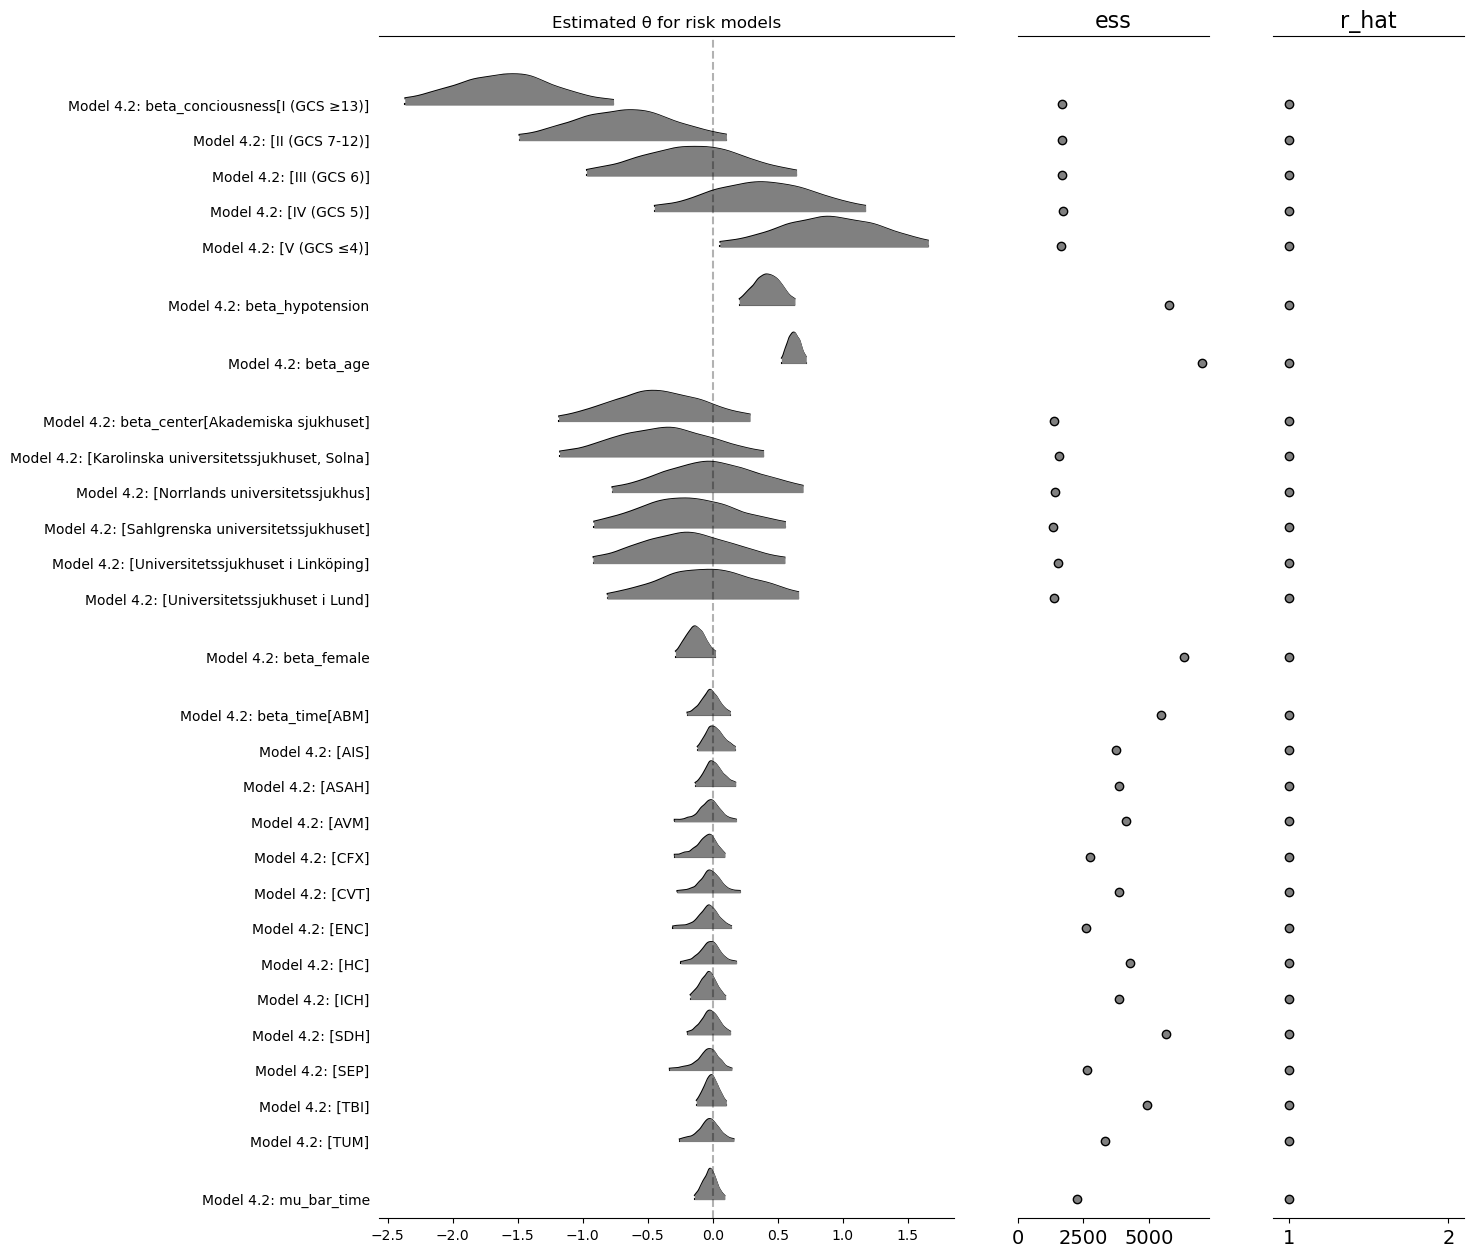

In [107]:
axes = az.plot_forest(
    [idata_4_2],
    model_names=[
        'Model 4.2'
    ],
    kind='ridgeplot', ess=True,
    r_hat=True,
    colors=['grey'],
    ridgeplot_overlap=0.7,
    hdi_prob=0.94,
    combined=True,
    var_names=['beta_conciousness', 'beta_hypotension', 'beta_age', 'beta_center', 'beta_female', 'beta_time', 'mu_bar_time'])
axes[0].set_title('Estimated θ for risk models')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3);

Conclusion: time-in-primary ICU is not an important predictor for 30-day mortality.

## What did we learn?
Nothing. Age, hypotension, low GCS, hypothermia, acidosis, hypoxia, ICH, AIS and TBI are all bad. Time in primary ICU is not an important predictor of 30-day mortality.

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray,pymc,arviz,pandas

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri May 03 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

pytensor: 2.19.0
xarray  : 2024.3.0
pymc    : 5.12.0
arviz   : 0.18.0
pandas  : 2.2.2

Watermark: 2.4.3

